In [1]:
%env PATH=/usr/local/cuda-11.5/bin:$PATH
%load_ext autoreload
%autoreload 2
%matplotlib widget

env: PATH=/usr/local/cuda-11.5/bin:$PATH


In [2]:
from pinns.prelude import *
from pinns.domain import Hypercube
from pinns.calc import divergence
from pinns.krr import krr, rbf
from pinns.elm import elm
from pinns.pde import poisson_dirichlet_qp_mc, poisson_dirichlet_ecqp_mc
from scipy.stats.qmc import Sobol

import itertools
import numpy as np
import matplotlib.pyplot as plt
from jax.config import config
config.update("jax_enable_x64", True)

In [3]:
a = 1.
b = 1.
c = 1.
domain = Hypercube((-a / 2, -b / 2, -c / 2), (a / 2, b / 2, c / 2))
x_dom = array(Sobol(3, seed=0).random_base2(12))
x_dom = domain.transform(x_dom)
x_bnd = array(Sobol(2, seed=1).random_base2(10))
x_bnd = domain.transform_bnd(x_bnd)


In [4]:
def plot_result(sol, ax):
    plt.sca(ax)
    N = 200
    x = np.linspace(-a/2, a/2, N)
    z = np.linspace(-c/2, c/2, N)

    X = np.array([_x for _x in itertools.product(x, z)])
    _X = jnp.asarray(X)
    _X = jnp.insert(_X, array([1]), zeros((N * N, 1)), 1)
    phi = np.array(sol(_X))

    p = ax.contourf(x, z, phi.reshape(N, N).T, 20, cmap=plt.get_cmap("autumn"), alpha=0.5)
    plt.colorbar(p)


def plot_model(model):
    fig = plt.figure(figsize=(8, 3))
    ax1, ax2 = fig.subplots(1, 2)
    fig.subplots_adjust(wspace=0.4)
    plot_result(model, ax1)
    ax1.set_title("Model")    
    plot_result(lambda x: abs(model(x) - norm(x, axis=-1) + 1), ax2)
    ax2.set_title("abs error")


In [14]:
from dataclasses import field
from chex import dataclass
from jaxopt.linear_solve import solve_normal_cg

@dataclass(frozen=True)
class StrayField:
    weights: flax.core.FrozenDict
    h: Callable
    l: Callable
    
    #@partial(jit, static_argnums=0)
    def __call__(self, x):
        l = self.l(x)
        h = self.h(x)
        phi1 = l * h @ self.weights['phi1']
        phi2 = l * h @ self.weights['phi2'] + h @ self.weights['g']
        return phi1 + phi2

@partial(jit, static_argnums=(0,1,2))
def _solve_stray_field(h, l, m, x_dom, x_bnd, surface_area, params0=None, **solver_kwargs):
    u = lambda x: l(x) * h(x)
    dk = vmap(jacfwd(u))(x_dom)
    if params0 is None:
        params0 = zeros((dk.shape[1],))
    M = vmap(m)(x_dom)
    p1 = solve_normal_cg(lambda x: jnp.tensordot(dk, x, (1, 0)), M, init=params0, **solver_kwargs)
    phi1 = lambda x: u(x) @ p1

    n = lambda x: -grad(l)(x)
    def phi2_solution_mc(x, x_bnd, A):
        eps = 1e-7
        def g(y):
            return dot(m(y), n(y)) - dot(grad(phi1)(y), n(y))
        
        dist = vmap(lambda x: norm(x - x_bnd, axis=-1))(x)
        _g = vmap(g)(x_bnd)
        def kernel(dist):
            idx = dist > eps
            newton_kernel = where(idx, 1 / dist, 0.)
            N = jnp.count_nonzero(idx)
            return A / (4 * pi * N) * dot(newton_kernel, _g)

        return vmap(kernel)(dist)

    phi_bnd = phi2_solution_mc(x_bnd, x_bnd, surface_area)

    H = vmap(h)(x_bnd)
    params_g = solve_normal_cg(lambda x: H @ x, phi_bnd, init=params0, ridge=0.001, **solver_kwargs)
    g = lambda x: h(x) @ params_g
    dg = vmap(grad(g))(x_dom)
    p2 = solve_normal_cg(lambda x: jnp.tensordot(dk, x, (1, 0)), -dg, init=params0)
    phi2 = lambda x: u(x) @ p2 + g(x)

    phi = jit(lambda x: phi1(x) + phi2(x))
    return freeze({'phi1': p1, 'phi2': p2, 'g': params_g})

def solve_stray_field(h, l, m, x_dom, x_bnd, surface_area, params0=None, **solver_kwargs):
    weights = _solve_stray_field(h, l, m, x_dom, x_bnd, surface_area, params0=None, **solver_kwargs)
    return StrayField(
        weights=weights,
        h=h, l=l
    )

In [15]:
weights = array(Sobol(4, seed=12345).random_base2(10))
W_elm = (weights[:, :3] * 2 - 1)
b_elm = (weights[:, 3] * 2 - 1)


def normalize(x):
    return x / norm(x, axis=-1, keepdims=True)

m_const = lambda x: array([0., 0., 1.])

def m_flower(x):
    mx = 1 / a * x[..., 0] * x[..., 2]
    my = 1 / c * x[..., 1] * x[..., 2] + 1 / b ** 3 * x[..., 1] ** 3 * x[..., 2] ** 3
    mz = ones_like(my)
    mag = stack([mx, my, mz], axis=-1)
    return normalize(mag)

def m_vortex(x):
    x, y, z = x[..., 0], x[..., 1], x[..., 2]
    rc = 0.14
    r = sqrt(x ** 2 + y ** 2)
    k = r**2 / rc**2
    mx = - y / r * sqrt(1 - exp(-4*k))
    my = x / r * sqrt(1 - exp(-4*k))
    mz = exp(-2*k)
    mag = stack([mx, my, mz], axis=-1)
    return normalize(mag)


m = m_flower# m_vortex
def l(x):
    x, y, z = x
    return -(x - a / 2) * (x + a / 2) * (y - b / 2) * (y + b / 2) * (z - c / 2) * (z + c / 2)
h = lambda x: tanh(W_elm @ x + b_elm)


In [16]:
phi_nn = solve_stray_field(h, l, m, x_dom, x_bnd, 6)

In [17]:
def ed(model, x):
    Ms = 1.
    mag = vmap(m)(x)
    H = lambda x: -grad(model)(x)
    e = lambda x: dot(m(x), H(x)) 
    return -Ms * (a * b * c) / 2 * jnp.sum(vmap(e)(x)) / len(x)

In [18]:
ed(phi_nn, x_dom)

DeviceArray(0.00518037, dtype=float64)

In [19]:
print(f"{abs(ed(phi_nn, x_dom)):.4e}")

5.1804e-03


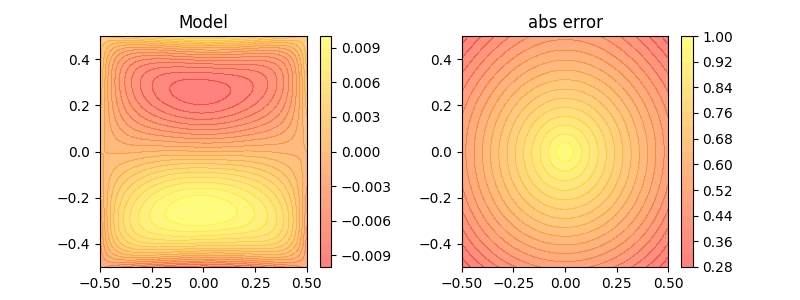

In [20]:
plot_model(vmap(phi_nn))

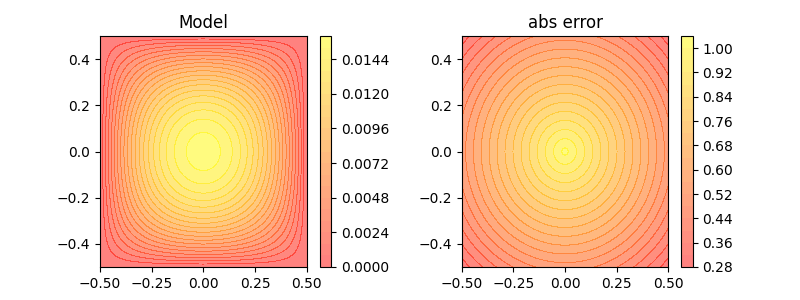

In [32]:
plot_model(vmap(l))

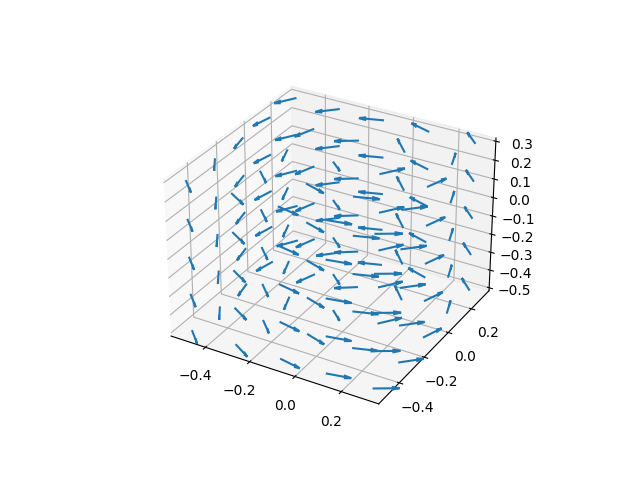

In [168]:
ax = plt.figure().add_subplot(projection='3d')

X = jnp.meshgrid(np.arange(-a/2, a/2, 0.2),
                 np.arange(-b/2, b/2, 0.2),
                 np.arange(-c/2, c/2, 0.2))

X = jnp.stack(X, axis=-1)
M = m(X)

ax.quiver(
    X[..., 0], 
    X[..., 1], 
    X[..., 2], 
    M[..., 0], 
    M[..., 1], 
    M[..., 2], 
    length=0.1)

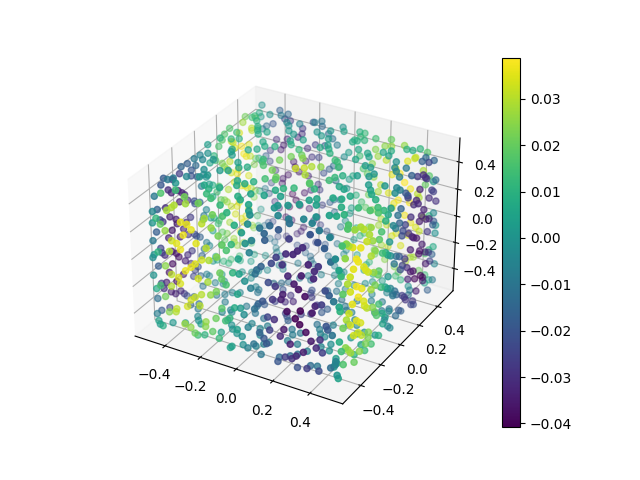

In [169]:
ax = plt.figure().add_subplot(projection='3d')

p = ax.scatter(x_bnd[:, 0], x_bnd[:, 1], x_bnd[:, 2], c=vmap(phi2)(x_bnd))
plt.colorbar(p)
